# Sampling from Uniform Distribution with Bregman Proximal Langevin Monte Carlo via The Bregman--Moreau Envelopes

In this notebook, we perform sampling from the uniform distribution on $\mathcal{C} := [a_1, b_1]\times[a_2, b_2]\times\cdots\times[a_d, b_d] \subset\mathbb{R}^d$, using the Moreau--Yosida unadjusted Langevin algorithm (MYULA) and the Bregman--Moreau unadjusted mirror Langevin algorithms (BMUMLA), which is impossible using subgradient-based approaches. 

## Import libraries

In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import matplotlib.pyplot as plt
import pandas as pd

### Plot function

In [2]:
def plot_single_uniform(df, i, a, b, num_bins):
    n, bins, patches = plt.hist(df[:,i-1], num_bins, density=True)
    x_min = a[i-1] * 1.25
    x_max = b[i-1] * 1.25
    plt.xlim([x_min, x_max])
    plt.ylim([0, 1.25/(b[i-1] - a[i-1])])
    x = np.arange(x_min, x_max, .01)
    pdf = []
    for j in range(int((x_max - x_min)/.01)):
        if (x[j] >= a[i-1] and x[j] <= b[i-1]):
            pdf.append(1/(b[i-1] - a[i-1]))  
        else:
            pdf.append(0.)
    plt.plot(x, pdf)
    plt.title(f'Dimension {i}')
    plt.show()



def plot_uniform(theta, a, b, num_bins=800):
    df = pd.DataFrame(data=theta).to_numpy()

    # the histogram of the data
    plot_single_uniform(df, 1, a, b, num_bins)    
    plot_single_uniform(df, 2, a, b, num_bins)    
    plot_single_uniform(df, 5, a, b, num_bins)    
    plot_single_uniform(df, 10, a, b, num_bins)
    plot_single_uniform(df, 20, a, b, num_bins)
    plot_single_uniform(df, 30, a, b, num_bins)
    plot_single_uniform(df, 40, a, b, num_bins)
    plot_single_uniform(df, 50, a, b, num_bins)
    plot_single_uniform(df, 60, a, b, num_bins)
    plot_single_uniform(df, 70, a, b, num_bins)
    plot_single_uniform(df, 80, a, b, num_bins)
    plot_single_uniform(df, 90, a, b, num_bins)
    plot_single_uniform(df, 100, a, b, num_bins)

### Function to compute the Euclidean projection $\operatorname{proj}_{[a, b]}$ onto the closed interval $[a,b]$, where $a < b$

$$
\operatorname{proj}_{[a, b]}(\boldsymbol{\theta}) = \left(\min\{b, \max\{a, \theta_i\}\} \right)_{1 \leqslant i \leqslant d}
$$

In [3]:
def proj_interval(theta, a, b):
    return np.minimum(b, np.maximum(a, theta))

### Specifications of the potential

In [4]:
d = 100
n = 100000

a = -np.arange(1, d+1)
b = np.arange(1, d+1)

beta = np.arange(d+1)[d+1:0:-1]

### Function for the MYULA main loop for sampling from the uniform distribution on $\mathcal{C} := [a_1, b_1]\times[a_2, b_2]\times\cdots\times[a_d, b_d] \subset\mathbb{R}^d$

In [5]:
def myula(gamma, lam, a, b, d=100, n=100000):
    np.random.seed(0)
    theta0 = np.random.normal(0, 1, d)
    theta = []

    for i in range(n):
        xi = rng.multivariate_normal(np.zeros(d), np.eye(d))
        theta_new = theta0 - gamma/lam * (theta0 - proj_interval(theta0, a, b)) + np.sqrt(2*gamma) * xi
        theta.append(theta_new)
        theta0 = theta_new

    return theta

### The MYULA main loop for sampling from the uniform distribution on $[-1,1]\times[-2,2]\times\cdots\times[-d,d]$ with $\gamma = 0.01$

In [6]:
theta1 = myula(1e-2, 1e0, a, b, d, n)

### Density and histogram plots of the samples generated by MYULA ($\gamma = 0.01$)

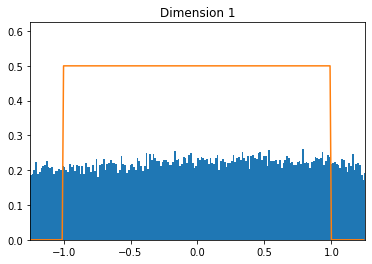

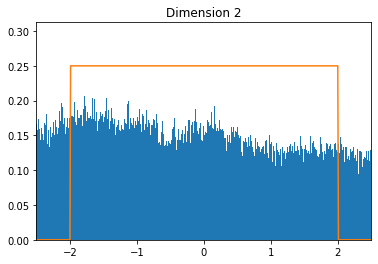

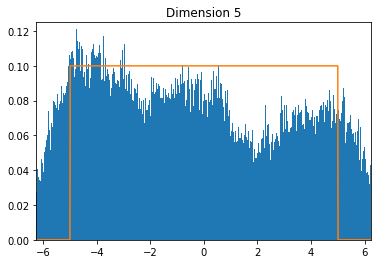

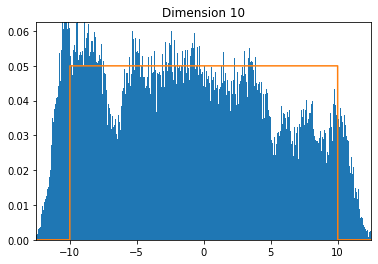

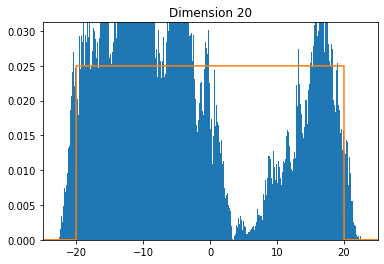

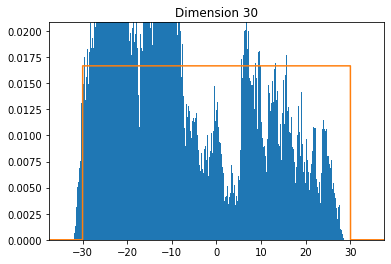

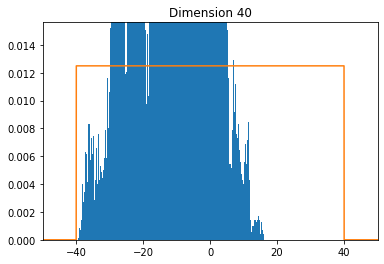

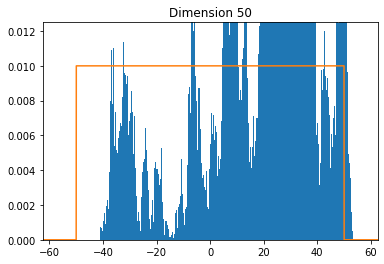

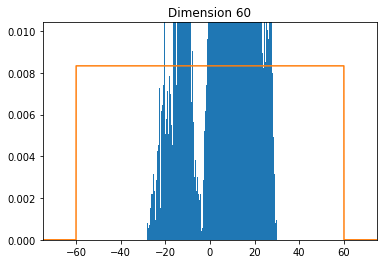

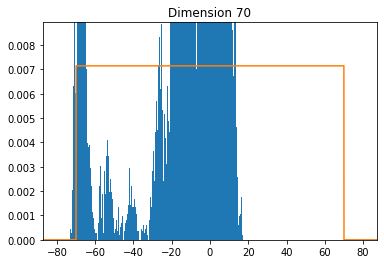

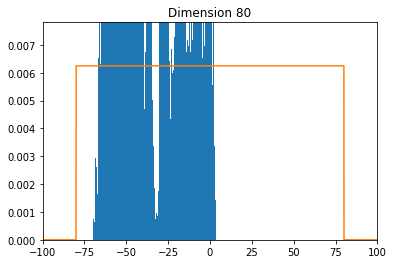

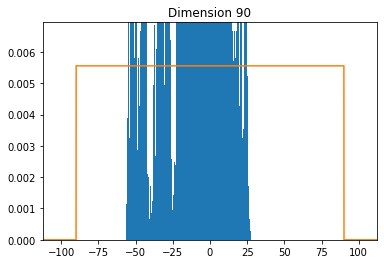

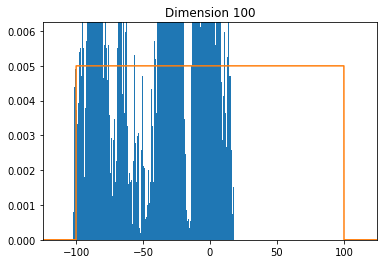

In [7]:
plot_uniform(theta1, a, b)

### Function to compute the gradient of the hypentropy mirror map

$$
\nabla \varphi(\boldsymbol{\theta}) = \left( \operatorname{arsinh}(\theta_i/\beta_i) \right)_{1 \leqslant i \leqslant d}^\top
$$

In [8]:
def grad_mirror_hyp(theta, beta) -> np.ndarray: 
    return np.arcsinh(theta / beta)

### Function to compute the gradient of the conjugate of the hypentropy mirror map

$$
\nabla\varphi^*(\boldsymbol{\theta}) = \left( \beta_i\sinh(\theta_i) \right)_{i\leqslant i \leqslant d}
$$

In [9]:
def grad_conjugate_mirror_hyp(theta, beta) -> np.ndarray:
    return beta * np.sinh(theta)

### Function for the BMUMLA main loop for sampling from the uniform distribution on $\mathcal{C} := [a_1, b_1]\times[a_2, b_2]\times\cdots\times[a_d, b_d] \subset\mathbb{R}^d$

In [10]:
def bmumla(gamma, lam, beta, a, b, d=100, n=100000):
    np.random.seed(0)
    theta0 = np.random.normal(0, 1, d)
    theta = []

    for i in range(n):
        xi = rng.multivariate_normal(np.zeros(d), np.eye(d))
        theta_new = grad_mirror_hyp(theta0, beta) - gamma/lam * (theta0 - proj_interval(theta0, a, b)) + np.sqrt(2*gamma) * (theta0**2 + beta**2)**(-.25) * xi
        theta_new = grad_conjugate_mirror_hyp(theta_new, beta)
        theta.append(theta_new)    
        theta0 = theta_new

    return theta

### The BMUMLA main loop for sampling from the uniform distribution on $[-1,1]\times[-2,2]\times\cdots\times[-d,d]$ with $\gamma=0.01$


In [11]:
theta2 = bmumla(1e-2, 1e0, 2*beta**.5, a, b, d, n)

### Density and histogram plots of the samples generated by BMUMLA ($\gamma = 0.005$)

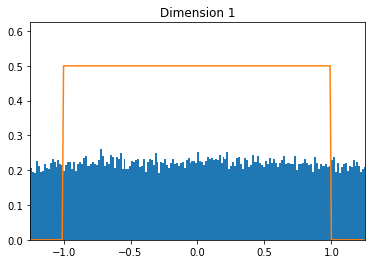

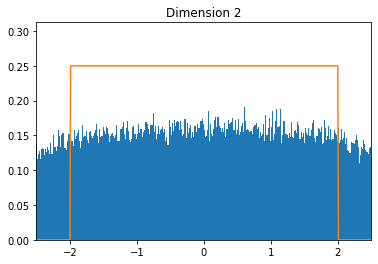

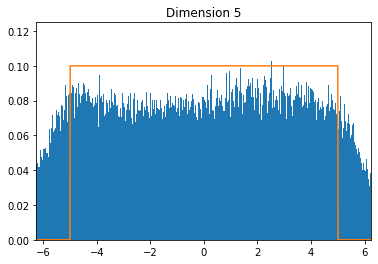

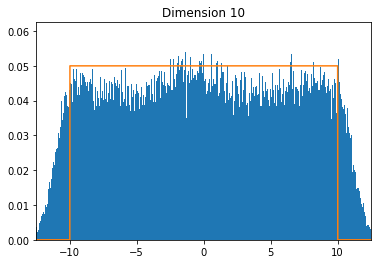

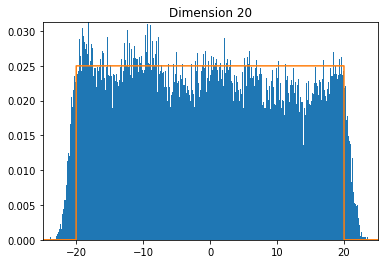

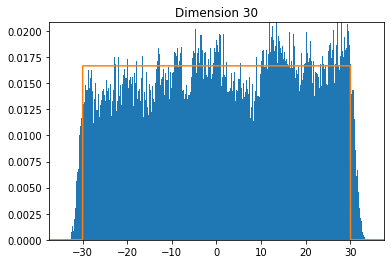

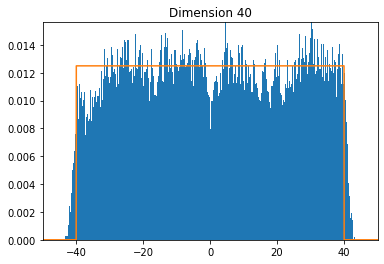

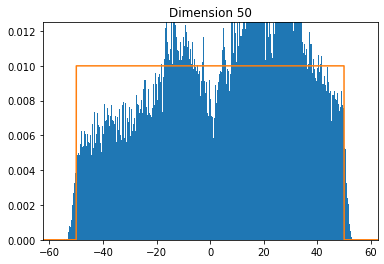

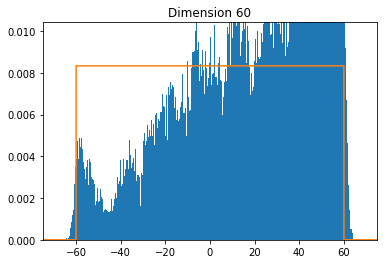

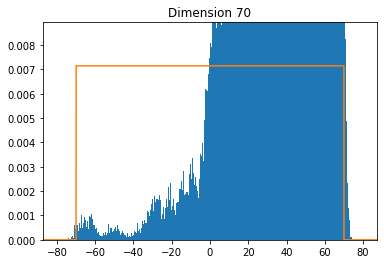

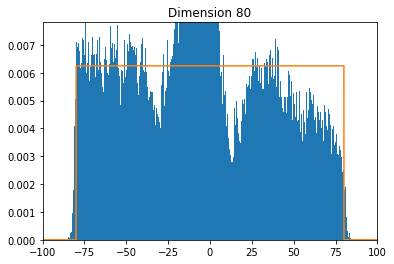

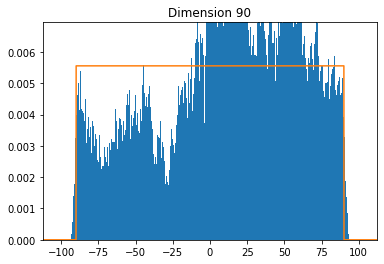

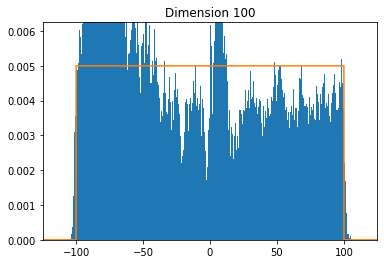

In [12]:
plot_uniform(theta2, a, b)

In [13]:
def plot_single_uniform_2(df, i, a, b, num_bins):
    n, bins, patches = plt.hist(df[:,i-1], num_bins, density=True)
    x_min = a[i-1] * 1.25
    x_max = b[i-1] * 1.25
    plt.xlim([x_min, x_max])
    plt.ylim([0, 1.25/(b[i-1] - a[i-1])])
    x = np.arange(x_min, x_max, .01)
    pdf = []
    for j in range(int((x_max - x_min)/.01)):
        if (x[j] >= a[i-1] and x[j] <= b[i-1]):
            pdf.append(1/(b[i-1] - a[i-1]))  
        else:
            pdf.append(0.)
    plt.plot(x, pdf)




def plot_uniform(theta, a, b, num_bins=800):
    df = pd.DataFrame(data=theta).to_numpy()

    # the histogram of the data
    plot_single_uniform(df, 1, a, b, num_bins)    
    plot_single_uniform(df, 2, a, b, num_bins)    
    plot_single_uniform(df, 5, a, b, num_bins)    
    plot_single_uniform(df, 10, a, b, num_bins)
    plot_single_uniform(df, 20, a, b, num_bins)
    plot_single_uniform(df, 30, a, b, num_bins)
    plot_single_uniform(df, 40, a, b, num_bins)
    plot_single_uniform(df, 50, a, b, num_bins)
    plot_single_uniform(df, 60, a, b, num_bins)
    plot_single_uniform(df, 70, a, b, num_bins)
    plot_single_uniform(df, 80, a, b, num_bins)
    plot_single_uniform(df, 90, a, b, num_bins)
    plot_single_uniform(df, 100, a, b, num_bins)


def plot_uniform_save(theta, a, b, alg, num_bins=800):
    df = pd.DataFrame(data=theta).to_numpy()

    # the histogram of the data
    # i = 1
    plt.figure(0)
    plt.style.use(['science', 'light'])
    plot_single_uniform_2(df, 1, a, b, num_bins)  
    # plt.title('1st dimension')
    # plt.show()
    plt.savefig(f'../fig/an_uniform_{alg}_1.pdf', dpi=500)  

    # i = 2
    plt.figure(1)
    plt.style.use(['science', 'light'])
    plot_single_uniform_2(df, 2, a, b, num_bins)  
    # plt.title('2nd dimension')
    # plt.show()
    plt.savefig(f'../fig/an_uniform_{alg}_2.pdf', dpi=500)

    # i = 5
    plt.figure(2)
    plt.style.use(['science', 'light'])
    plot_single_uniform_2(df, 5, a, b, num_bins)  
    # plt.title('5th dimension')
    # plt.show()
    plt.savefig(f'../fig/an_uniform_{alg}_5.pdf', dpi=500)  

    # i = 10
    plt.figure(3)
    plt.style.use(['science', 'light'])
    plot_single_uniform_2(df, 10, a, b, num_bins)  
    # plt.title('10th dimension')
    # plt.show()
    plt.savefig(f'../fig/an_uniform_{alg}_10.pdf', dpi=500)  

    # i = 25
    plt.figure(4)
    plt.style.use(['science', 'light'])
    plot_single_uniform_2(df, 25, a, b, num_bins)  
    # plt.title('25th dimension')
    # plt.show()
    plt.savefig(f'../fig/an_uniform_{alg}_25.pdf', dpi=500)  

    # i = 50
    plt.figure(5)
    plt.style.use(['science', 'light'])
    plot_single_uniform_2(df, 50, a, b, num_bins)  
    # plt.title('50th dimension')
    # plt.show()
    plt.savefig(f'../fig/an_uniform_{alg}_50.pdf', dpi=500)  

    # i = 75
    plt.figure(6)
    plt.style.use(['science', 'light'])
    plot_single_uniform_2(df, 75, a, b, num_bins)  
    # plt.title('75th dimension')
    # plt.show()
    plt.savefig(f'../fig/an_uniform_{alg}_75.pdf', dpi=500)  

    # i = 100
    plt.figure(7)
    plt.style.use(['science', 'light'])
    plot_single_uniform_2(df, 100, a, b, num_bins)  
    # plt.title('100th dimension')
    # plt.show()
    plt.savefig(f'../fig/an_uniform_{alg}_100.pdf', dpi=500)  

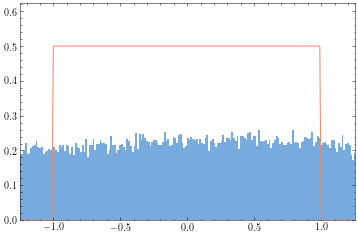

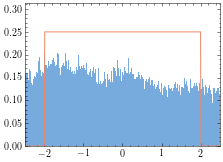

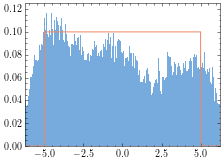

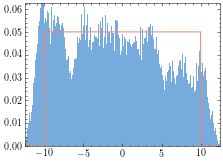

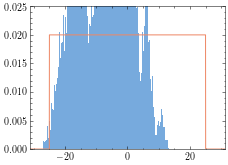

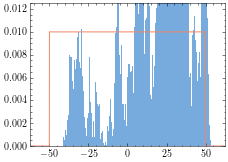

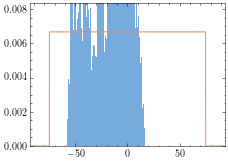

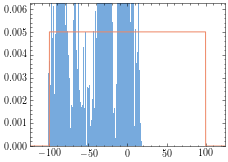

In [14]:
plot_uniform_save(theta1, a, b, "myula")

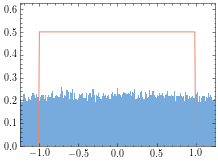

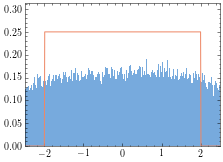

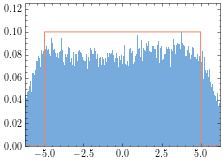

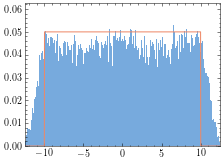

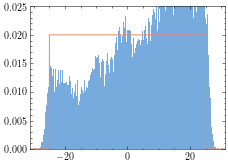

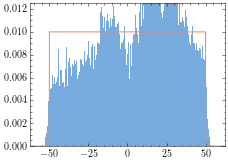

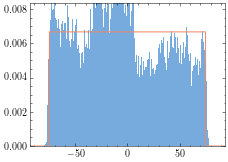

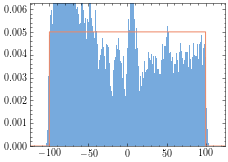

In [15]:
plot_uniform_save(theta2, a, b, "bmumla")